# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
%%capture
pip install matplotlib

In [2]:
%%capture
pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/s2/27yslc0j35s_xj4t3ln883cw0000gn/T/ipykernel_3000/555797462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
pd.set_option('display.max_columns', None)

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [5]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
50,C15164392z,Skoda Rapid,economy,petrol,3.34,2016,93681,2014,30.30,electro_bug
1698,Q-7254581y,Kia Rio X-line,economy,petrol,6.28,2013,40933,2018,55.16,engine_ignition
966,y17958394w,Hyundai Solaris,economy,petrol,3.60,2015,75192,2015,80.36,another_bug
852,p81056764h,Fiat 500,business,petrol,4.16,2015,87466,2018,29.43,gear_stick
1788,x-2282172P,Smart Coupe,economy,petrol,5.20,2014,71773,2021,40.81,engine_overheat


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [6]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
367091,E19424090a,a-1993580l,A1Y,2020-03-07,3.52,115,1489,30,64.0,13,2313.374187,0,-9.000052,-3.400
667287,K10548650W,v-1348159h,y1C,2020-03-31,6.72,406,4460,44,53.0,1,446.545949,0,3.110878,-1.721
676323,C46588323l,v14951627H,m1Q,2020-03-25,4.83,17,232,38,56.0,2,221.193140,0,-16.451498,-19.911
207068,k85133077n,O16337155M,k1p,2020-01-05,0.10,1171,15216,37,118.0,2,43672.973687,0,3.232454,0.000
640687,Z49442506q,t-6744951h,L1w,2020-01-11,4.33,7,65,48,74.0,1,355.119723,0,-0.706100,0.000


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [7]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
7081,47,7.9,361,1.0,w53146146a,0,2020-5-16
2317,32,7.9,46,0.0,M13397584q,0,2019-11-5
3596,41,8.2,1810,6.0,l17508830g,0,2021-8-28
4756,21,8.6,1112,7.0,N22609412O,1,2020-12-3
13889,34,8.5,2258,3.0,j17183153u,0,2021-12-25


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [8]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
137949,t-1655791x,OB,2019-12-8 21:54,reparking,1.0,25
48834,K19878738u,FL,2020-2-29 6:58,reparking,1.0,27
57857,N22527355E,JO,2019-4-15 7:58,reparking,1.0,26
141258,W-1211129e,LN,2019-11-22 21:45,reparking,1.0,25
74467,W-1663352r,UV,2019-5-17 14:1,refuel,1.0,35


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Создание признаков и объединение данных

Набор данных должен содержать только те признаки, которые позволят находить по задаче необходимые свойства, а точнее построить модели, способные решать задачи классификации, прогноза, и другого анализа. 

Итак, дано: 

3 набора данных у которых есть общие id поля. Разумнее их объединить сначала, что в целом получился у нас понятный датасет и мы могли сразу убрать мало интересующие нас признаки. 


In [9]:
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822


In [10]:
rides_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739500 entries, 0 to 739499
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            739500 non-null  object 
 1   car_id             739500 non-null  object 
 2   ride_id            739500 non-null  object 
 3   ride_date          739500 non-null  object 
 4   rating             739500 non-null  float64
 5   ride_duration      739500 non-null  int64  
 6   ride_cost          739500 non-null  int64  
 7   speed_avg          739500 non-null  int64  
 8   speed_max          736139 non-null  float64
 9   stop_times         739500 non-null  int64  
 10  distance           739500 non-null  float64
 11  refueling          739500 non-null  int64  
 12  user_ride_quality  736872 non-null  float64
 13  deviation_normal   739500 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 79.0+ MB


In [11]:
rides_info.describe()

,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
count,739500.000000,739500.000000,7.395000e+05,739500.000000,736139.000000,739500.000000,7.395000e+05,739500.000000,736872.000000,739500.000000
mean,4.471255,1669.619079,2.093108e+04,47.012270,83.787431,1.337385,7.839567e+04,0.000004,-0.273648,-1.341434
std,2.130867,6356.635586,8.731537e+04,12.690333,29.642707,2.369775,3.158147e+05,0.002014,11.657122,19.581792
min,0.000000,2.000000,7.000000e+00,25.000000,27.900000,0.000000,1.843634e+00,0.000000,-65.776864,-126.883000
25%,3.120000,27.000000,2.980000e+02,38.000000,64.000000,0.000000,7.925952e+02,0.000000,-6.975054,-9.358000
50%,4.470000,44.000000,5.050000e+02,46.000000,75.275957,1.000000,1.452544e+03,0.000000,0.074098,0.000000
75%,5.830000,69.000000,8.880000e+02,52.000000,97.000000,2.000000,2.247795e+03,0.000000,6.461507,7.539250
max,10.000000,43956.000000,2.007346e+06,100.000000,209.982840,23.000000,3.606051e+06,1.000000,69.574650,98.743000


In [12]:
driver_info.head()

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,19.0,l17437965W,1,2019-4-2
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19
2,59,7.8,947,4.0,g11098715c,0,2021-1-15
3,37,7.0,18,4.0,U12618125q,0,2019-11-20
4,39,8.2,428,7.0,A14375829B,0,2019-7-23


In [13]:
driver_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15153 entries, 0 to 15152
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 15153 non-null  int64  
 1   user_rating         15153 non-null  float64
 2   user_rides          15153 non-null  int64  
 3   user_time_accident  14182 non-null  float64
 4   user_id             15153 non-null  object 
 5   sex                 15153 non-null  int64  
 6   first_ride_date     15153 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 828.8+ KB


In [14]:
driver_info.describe()

,age,user_rating,user_rides,user_time_accident,sex
count,15153.000000,15153.000000,15153.000000,14182.000000,15153.000000
mean,33.581073,8.109345,871.015442,10.129601,0.499967
std,9.919271,0.668246,573.512378,8.867482,0.500016
min,18.000000,5.800000,0.000000,0.000000,0.000000
25%,25.000000,7.700000,421.000000,4.000000,0.000000
50%,33.000000,8.100000,876.000000,9.000000,0.000000
75%,41.000000,8.600000,1145.000000,14.000000,1.000000
max,63.000000,10.000000,3316.000000,86.000000,1.000000


In [15]:
fix_info.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47


In [16]:
fix_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   car_id          146000 non-null  object 
 1   worker_id       146000 non-null  object 
 2   fix_date        146000 non-null  object 
 3   work_type       146000 non-null  object 
 4   destroy_degree  146000 non-null  float64
 5   work_duration   146000 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [17]:
fix_info.describe()

,destroy_degree,work_duration
count,146000.000000,146000.000000
mean,3.510022,26.144527
std,2.752983,12.642266
min,1.000000,1.000000
25%,1.000000,20.000000
50%,3.200000,26.000000
75%,5.500000,31.000000
max,10.000000,74.000000


Проведем группировку данных для каждой машины
- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.
+ +общая заправка, общая стоимость поездок и общее количество остановок. 

In [18]:
aggregated_data = rides_info.groupby('car_id').agg(min_rating=pd.NamedAgg(column='rating', aggfunc='min'),
    avg_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    total_distance=pd.NamedAgg(column='distance', aggfunc='sum'),
    max_speed=pd.NamedAgg(column='speed_max', aggfunc='max'),
    total_stop_times=pd.NamedAgg(column='stop_times', aggfunc='sum'),
    total_refueling=pd.NamedAgg(column='refueling', aggfunc='sum'),
    total_ride_cost=pd.NamedAgg(column='ride_cost', aggfunc='sum'),                                            
    total_trips=pd.NamedAgg(column='ride_id', aggfunc='count')).reset_index()

In [19]:
aggregated_data

,car_id,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips
0,A-1049127W,0.10,4.255172,1.125753e+07,179.729652,142,0,2645050,174
1,A-1079539w,0.10,4.088046,1.912765e+07,184.505566,144,0,4699301,174
2,A-1162143G,0.10,4.662299,2.995194e+06,180.000000,721,0,800344,174
3,A-1228282M,0.10,4.225172,1.793685e+07,182.446070,132,0,4764037,174
4,A-1339912r,0.10,4.690115,1.202552e+07,152.000000,155,0,2816285,174
...,...,...,...,...,...,...,...,...,...
4245,z73688663a,0.10,4.808448,1.113943e+07,165.000000,129,0,2708689,174
4246,z73740510r,0.28,4.699655,7.215961e+06,117.397405,622,0,2155613,174
4247,z86911952C,0.00,4.430977,2.135104e+07,173.428116,136,0,4697507,174
4248,z91353693Z,0.10,5.326092,1.614384e+07,106.089167,139,0,4834945,174


In [20]:
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822


In [21]:
data = pd.merge(rides_info, aggregated_data, on='car_id', how = 'left')

In [22]:
data.shape

(739500, 22)

In [23]:
data = pd.merge(data, fix_info, on='car_id', how = 'left')

In [24]:
data.shape

(25404000, 27)

## Мерджинг увеличивает объем данных значительно. Пока не придумал как этого избежать. Из-за этого многие задания берут очень много времени для выполнения. 

In [25]:
data = pd.merge(data, driver_info, on='user_id', how = 'left')

In [26]:
data.columns

Index(['user_id', 'car_id', 'ride_id', 'ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'total_trips', 'worker_id',
       'fix_date', 'work_type', 'destroy_degree', 'work_duration', 'age',
       'user_rating', 'user_rides', 'user_time_accident', 'sex',
       'first_ride_date'],
      dtype='object')

In [27]:
data.shape

(25404000, 33)

In [28]:
data.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips,worker_id,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,OO,2020-10-14 14:0,reparking,1.0,36,18,8.0,228,9.0,1,2019-9-16
1,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,SV,2019-6-27 16:56,refuel_check,1.0,31,18,8.0,228,9.0,1,2019-9-16
2,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,ZF,2019-5-9 16:51,refuel_check,1.0,32,18,8.0,228,9.0,1,2019-9-16
3,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,TY,2019-7-27 0:13,repair,7.5,44,18,8.0,228,9.0,1,2019-9-16
4,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,YV,2020-11-24 18:39,repair,5.9,23,18,8.0,228,9.0,1,2019-9-16


### Идеи для новых признаков

1.   Например, время которое прошло между первой поездкой и аварией
2.   Сколько заработала машина с учетом ремонта
3.   Средний ущерб для машины (максимальный, минимальный) 



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

На этот вопрос можно будет ответить, когда проверятся все гипотезы. Сначала поищем в том что есть. 

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25404000 entries, 0 to 25403999
Data columns (total 33 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   car_id              object 
 2   ride_id             object 
 3   ride_date           object 
 4   rating              float64
 5   ride_duration       int64  
 6   ride_cost           int64  
 7   speed_avg           int64  
 8   speed_max           float64
 9   stop_times          int64  
 10  distance            float64
 11  refueling           int64  
 12  user_ride_quality   float64
 13  deviation_normal    float64
 14  min_rating          float64
 15  avg_rating          float64
 16  total_distance      float64
 17  max_speed           float64
 18  total_stop_times    int64  
 19  total_refueling     int64  
 20  total_ride_cost     int64  
 21  total_trips         int64  
 22  worker_id           object 
 23  fix_date            object 
 24  work_type           ob

In [30]:
data.head(2)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips,worker_id,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,OO,2020-10-14 14:0,reparking,1.0,36,18,8.0,228,9.0,1,2019-9-16
1,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,SV,2019-6-27 16:56,refuel_check,1.0,31,18,8.0,228,9.0,1,2019-9-16


In [31]:
#Удаляем константы из датасета
constant_columns = data.columns[data.nunique() <= 1]
data = data.drop(columns=constant_columns)

In [32]:
data.columns

Index(['user_id', 'car_id', 'ride_id', 'ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'worker_id', 'fix_date',
       'work_type', 'destroy_degree', 'work_duration', 'age', 'user_rating',
       'user_rides', 'user_time_accident', 'sex', 'first_ride_date'],
      dtype='object')

In [33]:
#Удаляем колонки с id
data = data [['ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'fix_date',
       'work_type', 'destroy_degree', 'work_duration', 'age', 'user_rating',
       'user_rides', 'user_time_accident', 'sex', 'first_ride_date']]

In [34]:
data.tail(5)

,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
25403995,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2019-9-28 16:54,repair,3.6,5,21,7.0,193,0.0,1,2020-4-4
25403996,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2019-11-23 8:36,reparking,1.0,26,21,7.0,193,0.0,1,2020-4-4
25403997,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2019-6-29 23:5,repair,3.8,1,21,7.0,193,0.0,1,2020-4-4
25403998,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2019-2-18 18:41,refuel,1.0,30,21,7.0,193,0.0,1,2020-4-4
25403999,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2021-5-27 16:22,refuel_check,1.0,29,21,7.0,193,0.0,1,2020-4-4


In [36]:
correlation_matrix = data[numeric_columns].corr()

<Axes: >

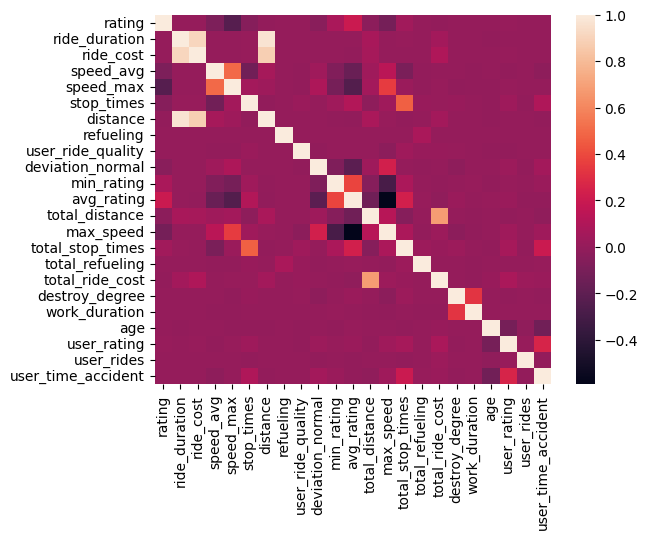

In [37]:
sns.heatmap(correlation_matrix)

In [38]:
correlation_matrix

,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident
rating,1.000000,-0.001248,-0.001021,-0.085969,-0.235871,-0.054392,-0.006362,0.001243,0.000048,-0.042721,0.075672,0.197967,-0.027076,-0.117276,0.046365,0.001671,-0.003294,0.003539,0.000917,0.001603,0.004885,-0.000670,-0.000125
ride_duration,-0.001248,1.000000,0.912823,-0.000775,0.001141,0.009082,0.964464,0.003591,-0.000029,-0.000204,0.000871,0.000378,0.071442,0.001534,0.005894,0.000722,0.053971,0.000350,-0.000020,-0.001976,-0.000241,0.000037,-0.000517
ride_cost,-0.001021,0.912823,1.000000,-0.000280,0.000699,0.006922,0.880827,0.003116,0.000631,0.000297,-0.000403,-0.001580,0.064555,0.002789,0.001443,-0.000062,0.094949,0.000177,-0.000284,0.000215,0.006802,0.001962,0.001021
speed_avg,-0.085969,-0.000775,-0.000280,1.000000,0.498303,-0.131358,0.065835,0.000419,-0.005639,0.039011,-0.072792,-0.158229,0.041318,0.135973,-0.096566,-0.003051,0.004061,-0.001150,-0.002166,0.000103,-0.003013,-0.000827,-0.020724
speed_max,-0.235871,0.001141,0.000699,0.498303,1.000000,0.048341,0.033203,-0.000627,-0.005161,0.086666,-0.109957,-0.246243,0.053321,0.348987,0.021489,-0.004047,0.008353,-0.009106,-0.002209,-0.001947,0.005143,-0.000954,0.001687
stop_times,-0.054392,0.009082,0.006922,-0.131358,0.048341,1.000000,-0.007986,-0.000285,0.018041,0.000799,0.039976,0.109382,-0.026027,0.037931,0.467031,0.013439,0.007100,0.011540,0.001541,-0.002605,0.030177,-0.002371,0.093600
distance,-0.006362,0.964464,0.880827,0.065835,0.033203,-0.007986,1.000000,0.002705,-0.000402,0.002472,-0.003952,-0.010472,0.076570,0.009883,-0.004267,0.000010,0.052059,0.000023,-0.000144,-0.002294,-0.000456,-0.000135,-0.002469
refueling,0.001243,0.003591,0.003116,0.000419,-0.000627,-0.000285,0.002705,1.000000,0.000916,-0.001026,0.000288,0.000640,0.000010,-0.000208,0.002181,0.075783,-0.000049,-0.000096,-0.000360,0.001065,-0.000703,-0.001241,-0.000878
user_ride_quality,0.000048,-0.000029,0.000631,-0.005639,-0.005161,0.018041,-0.000402,0.000916,1.000000,-0.011506,0.003700,0.001321,-0.000015,-0.026367,0.038737,0.014148,0.011622,0.005117,-0.000040,-0.004421,-0.002867,-0.000209,0.003366
deviation_normal,-0.042721,-0.000204,0.000297,0.039011,0.086666,0.000799,0.002472,-0.001026,-0.011506,1.000000,-0.078819,-0.216056,0.031727,0.234291,0.000841,-0.003674,0.004660,-0.025913,0.002467,-0.001370,0.023658,-0.002375,0.053708


In [40]:
abs_corr_matrix = correlation_matrix.abs()
sorted_pairs = abs_corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)
unique_sorted_pairs = sorted_pairs.drop_duplicates()
top4_pairs = unique_sorted_pairs[1:10] 

print(top4_pairs)

ride_duration     distance          0.964464
                  ride_cost         0.912823
distance          ride_cost         0.880827
total_ride_cost   total_distance    0.679893
avg_rating        max_speed         0.592398
speed_max         speed_avg         0.498303
total_stop_times  stop_times        0.467031
avg_rating        min_rating        0.382246
speed_max         max_speed         0.348987
dtype: float64


In [41]:
#Половой признак, возраст скорей всего никак не влияет на решение задачи для нас
numeric_columns = ['ride_duration',
       'ride_cost', 'speed_max', 'stop_times', 'distance',
       'destroy_degree', 
       'user_rides', 'user_time_accident']
categorial_columns = ['work_type']
date_columns = ['ride_date', 'fix_date', 'first_ride_date']

 # В общем данных много. Надо сделать меньше набор данных, чтобы можно было выполнить задание. В дальнейшем в работе когда дойдем до конца, и будет возможность взять мощнее оборудование, прогоним на полном наборе данных.

In [42]:
data = data [numeric_columns+categorial_columns]

In [43]:
data.shape

(25404000, 9)

In [44]:
sample_size = 1000

data = data.sample(n=sample_size, replace=False, random_state=123)

In [45]:
data.shape

(1000, 9)

In [46]:
%%capture
pip install phik

In [47]:
#долго работает код, в целом дает ли он какое-то представление о корреляции?
import phik
from phik import resources, report

phik_matrix = data.phik_matrix(interval_cols = numeric_columns)

interval columns not set, guessing: ['ride_duration', 'ride_cost', 'speed_max', 'stop_times', 'distance', 'destroy_degree', 'user_rides', 'user_time_accident']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/phik/outliers.py:200: RuntimeWarning: invalid value encountered in scalar subtract
  logmidp = np.log(0.5) + lp + np.log(1 + np.exp(lp1 - lp))


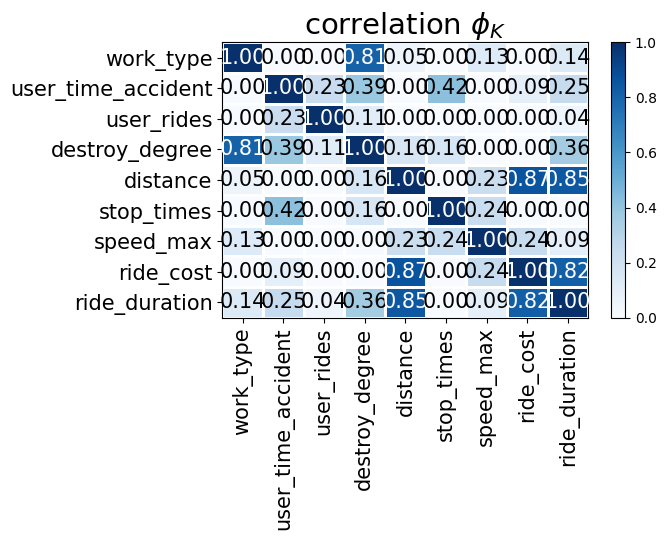

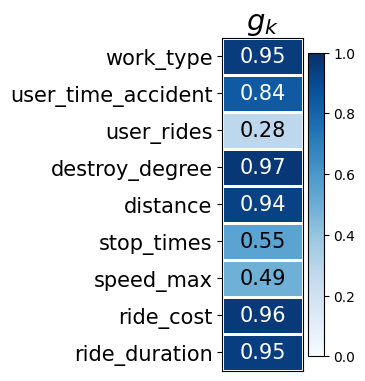

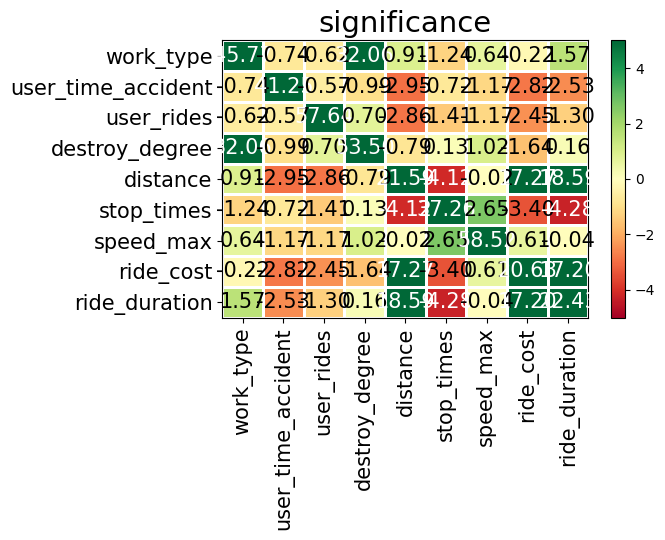

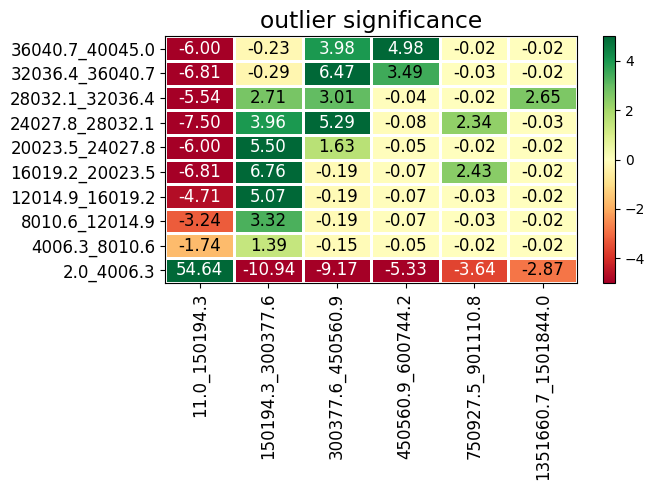

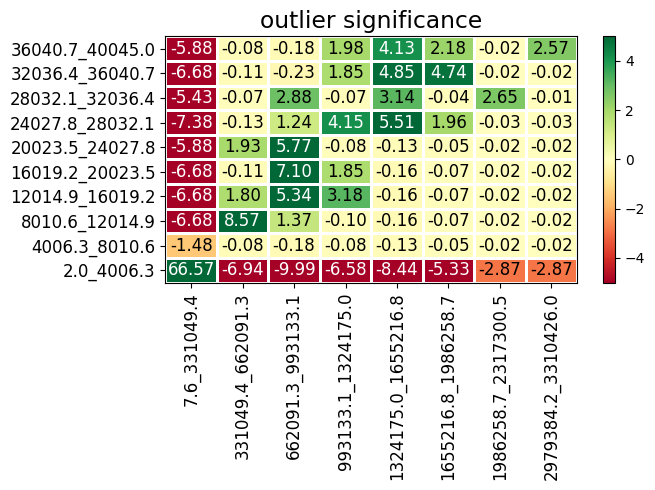

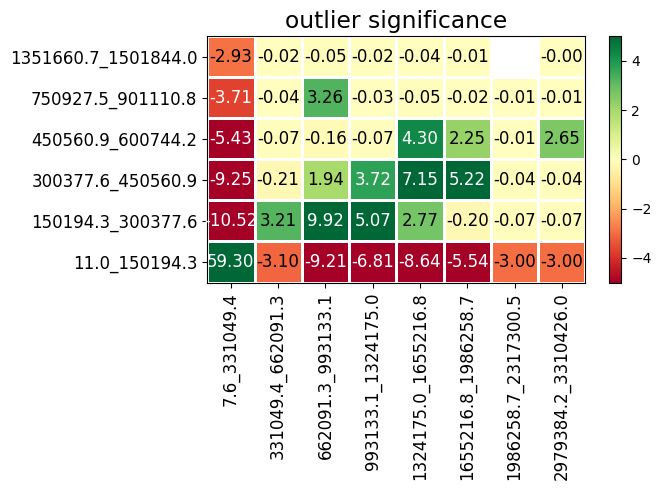

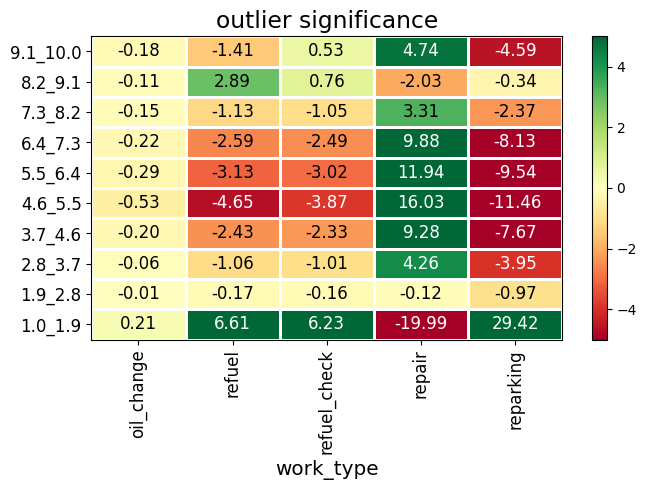

In [48]:
from phik import report
rep = report.correlation_report(data, significance_threshold=3, correlation_threshold=0.5)

In [49]:
import itertools

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

%matplotlib inline

In [51]:
# bin the interval variables
data_binned, binning_dict = bin_data(data, cols=numeric_columns, retbins=True)

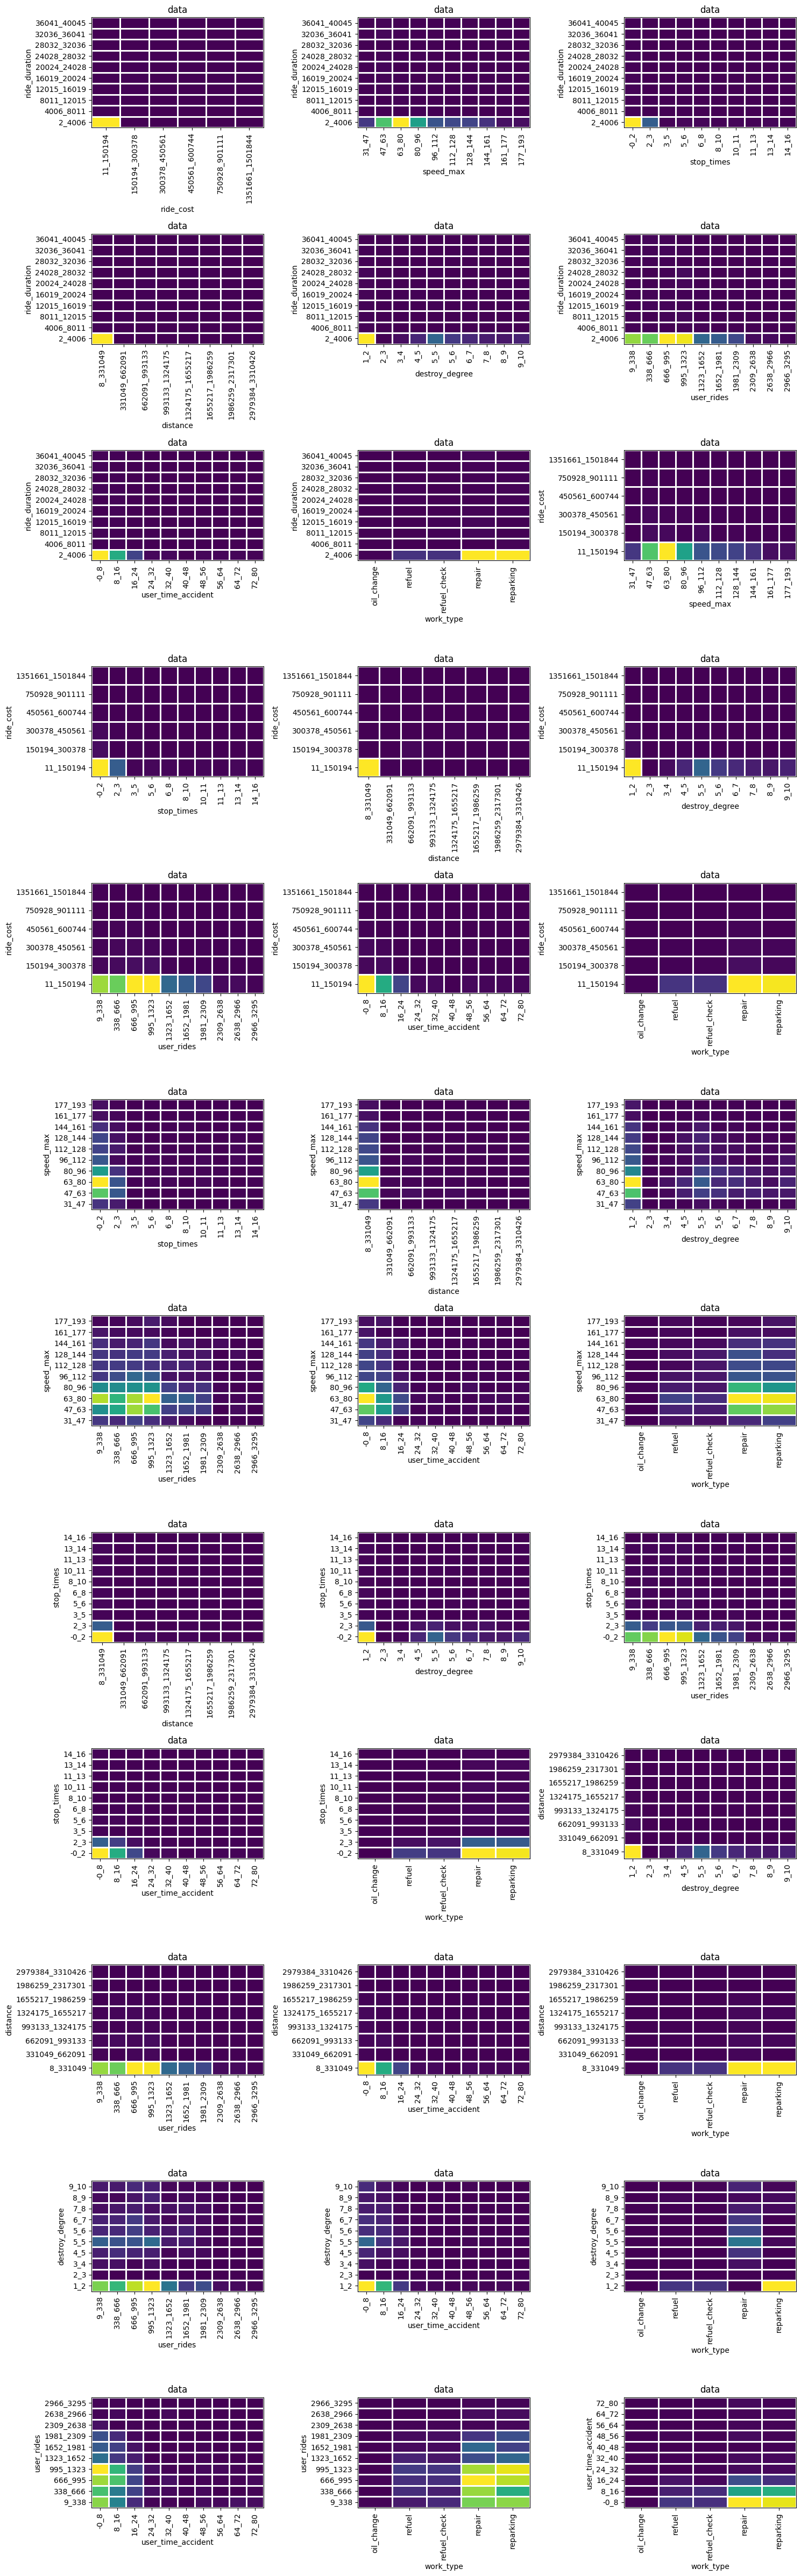

In [52]:
plt.rc('text', usetex=False)

n=0
for i in range(len(data.columns)):
    n=n+i
    
ncols=3
nrows=int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15,4*nrows))
ndecimals = 0

for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
    c = int(i%ncols)
    r = int((i-c)/ncols )

    # get data
    c0, c1 = comb
    datahist = data_binned.groupby([c0,c1])[c0].count().to_frame().unstack().fillna(0)
    datahist.columns = datahist.columns.droplevel()
    
    # plot data
    img = axes[r][c].pcolormesh(datahist.values, edgecolor='w', linewidth=1)
    
    # axis ticks and tick labels
    if c0 in binning_dict.keys():
        ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
                   for i in range(len(binning_dict[c0]))]
    else:
        ylabels = datahist.index

    if c1 in binning_dict.keys():        
        xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
                    for i in range(len(binning_dict[c1]))]
    else:
        xlabels = datahist.columns
    
    # axis labels
    axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
    axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
    axes[r][c].set_xticklabels(xlabels, rotation='vertical')
    axes[r][c].set_yticklabels(ylabels, rotation='horizontal')    
    axes[r][c].set_xlabel(datahist.columns.name)
    axes[r][c].set_ylabel(datahist.index.name)    
    axes[r][c].set_title('data')
    
plt.tight_layout()

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

train_data = data[numeric_columns+categorial_columns]

rf_model = RandomForestClassifier().fit(train_data.drop('work_type', axis=1), train_data['work_type'])
result = permutation_importance(rf_model, train_data.drop('work_type', axis=1), train_data['work_type'], n_repeats=10)
perm_sorted_idx = result.importances_mean.argsort()

In [54]:
import numpy as np

# Получить имена признаков из датафрейма train_data
feature_names = train_data.drop('work_type', axis=1).columns

# Получить упорядоченные имена признаков по их важности
sorted_feature_names = feature_names[perm_sorted_idx]

# Вывести упорядоченные имена признаков с их важностью
for name, importance in zip(sorted_feature_names, result.importances_mean[perm_sorted_idx]):
    print(f'{name}: {importance}')

stop_times: 0.03480000000000003
user_rides: 0.06419999999999998
ride_duration: 0.06869999999999996
speed_max: 0.07009999999999995
user_time_accident: 0.07049999999999995
ride_cost: 0.07749999999999996
distance: 0.08009999999999996
destroy_degree: 0.49750000000000005


In [55]:
%%capture
pip install shap

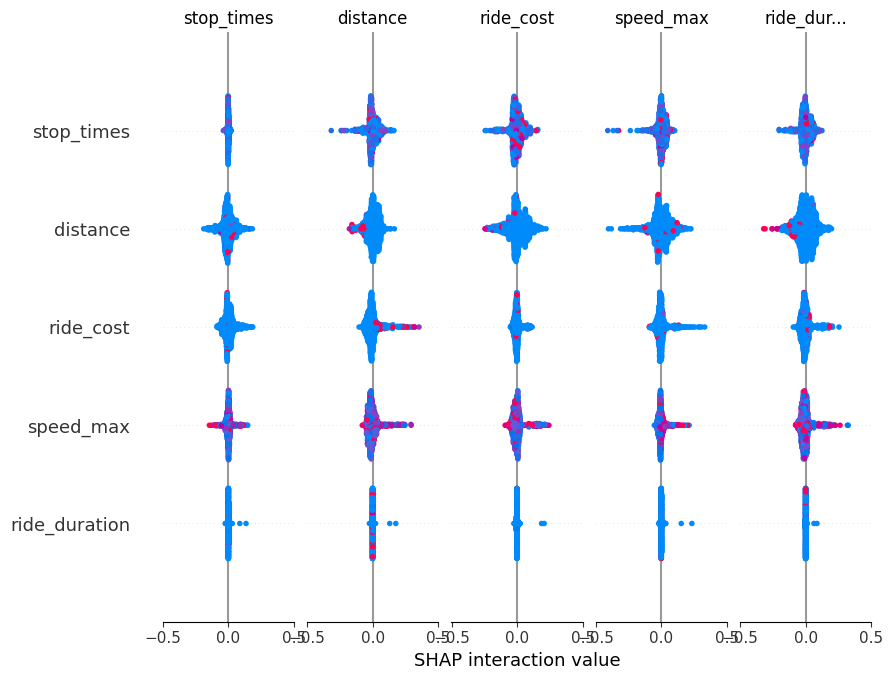

In [57]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(train_data.drop('work_type', axis=1))

shap.summary_plot(shap_values, train_data.drop('work_type', axis=1))

Распределение точек вдоль оси x (SHAP значения) показывает, насколько велико влияние признака на прогноз. Например, если большинство точек признака distance сгруппированы вокруг положительных значений SHAP, это может означать, что большее расстояние увеличивает вероятность прогнозируемого исхода. Наличие точек как с положительными, так и с отрицательными значениями SHAP для одного признака может указывать на более сложное взаимодействие этого признака с исходом в различных условиях.

In [60]:
%%capture
pip install catboost

In [62]:
from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier(iterations=100, verbose=False)
cat_model.fit(train_data.drop('work_type', axis=1), train_data['work_type'])
feature_importances = cat_model.get_feature_importance(Pool(train_data.drop('work_type', axis=1), train_data['work_type']))

feature_names = train_data.drop('work_type', axis=1).columns
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df)

              Feature  Importance
5      destroy_degree   50.845662
2           speed_max    9.530070
6          user_rides    8.599073
7  user_time_accident    7.892611
3          stop_times    6.367210
4            distance    6.126074
0       ride_duration    5.907105
1           ride_cost    4.732193


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [65]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [63]:
features2drop = [...] # то, что надо выбросить
targets = ['work_type'] # таргеты
cat_features = ['work_type'] # категориальные признаки

num_features = ['ride_duration',
       'ride_cost', 'speed_max', 'stop_times', 'distance',
       'destroy_degree', 
       'user_rides', 'user_time_accident'] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 1 ['work_type']
Числовые признаки: 8 ['ride_duration', 'ride_cost', 'speed_max', 'stop_times', 'distance', 'destroy_degree', 'user_rides', 'user_time_accident']
Целевые переменные ['work_type']


In [105]:
data[targets].value_counts()

work_type   
repair          440
reparking       424
refuel           69
refuel_check     65
oil_change        2
Name: count, dtype: int64

Accuracy: 0.82


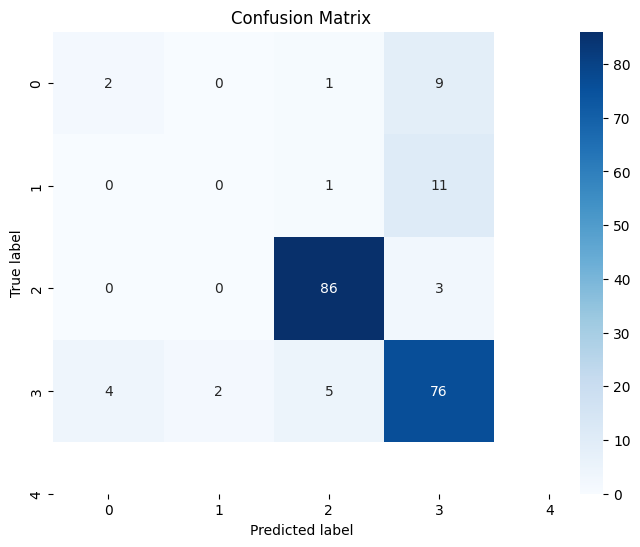

In [106]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

X = data[num_features]
y = data[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_model = CatBoostClassifier(iterations=100, verbose=False)

cat_model.fit(X_train, y_train, plot=False)

# Оценка модели
y_pred = cat_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Оценка модели
y_pred = cat_model.predict(X_test)

# Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Построение матрицы ошибок с использованием seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

              precision    recall  f1-score   support

      refuel       0.33      0.17      0.22        12
refuel_check       0.00      0.00      0.00        12
      repair       0.92      0.97      0.95        89
   reparking       0.77      0.87      0.82        87

    accuracy                           0.82       200
   macro avg       0.51      0.50      0.50       200
weighted avg       0.77      0.82      0.79       200



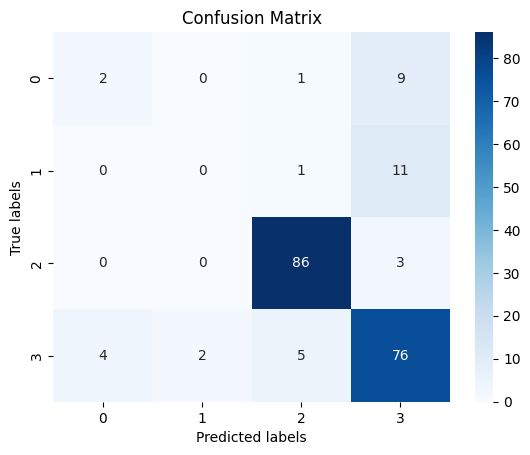

In [107]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns

#Генерация classification_report
y_pred = cat_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

#Построение и визуализация матрицы 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


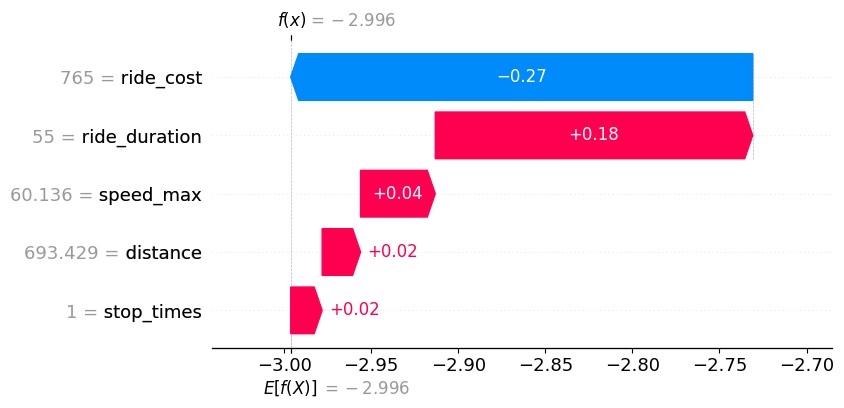

In [110]:
explainer = shap.Explainer(cat_model)
shap_values = explainer.shap_values(X)
class_index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[class_index][0], base_values=explainer.expected_value[class_index], data=X.iloc[0]), max_display=20)

plt.show()

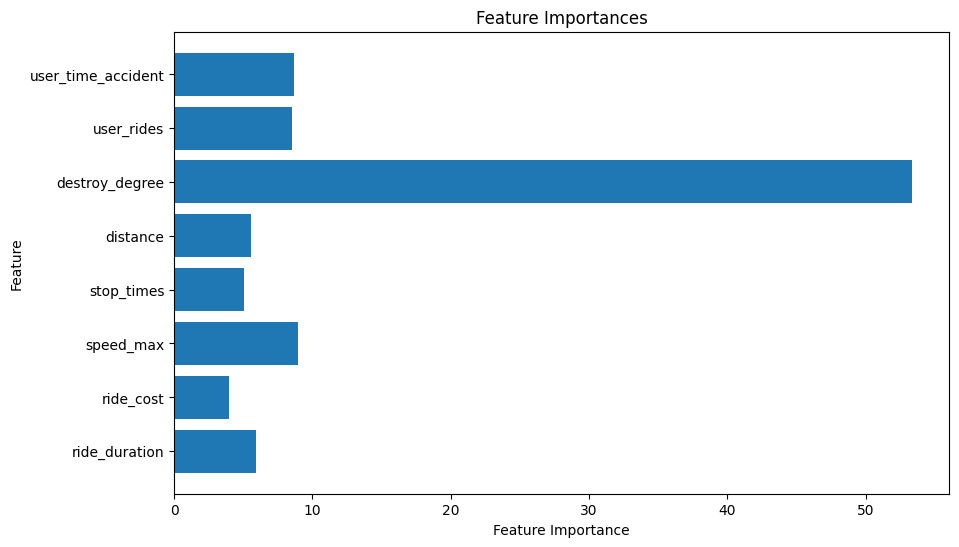

In [112]:
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.